Initially I forked from this [kernel](https://www.kaggle.com/khursani8/fast-ai-starter-resnet34), changed architecture to ResNet 50, added augmentation and did some initial tuning of parameters like learning rate.

In later versions I plugged in OptimizedRounder class and Ben's processing functions.

# Libraries import

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
from fastai.callbacks import *

import PIL
import cv2

In [3]:
# Set seed for all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Ben's Preprocessing Functions

These functions are taken from famous kernel https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping. Below I am showing how they can be applied for fast.ai pipeline. 

In [4]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

# Data

In [5]:
PATH = Path('../input/aptos2019-blindness-detection')

In [6]:
df = pd.read_csv(PATH/'train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
!ls ../input/resnet50/

resnet50.pth


In [8]:
# copy pretrained weights for resnet50 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [9]:
df.diagnosis.value_counts() 

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

So our train set is definitely imbalanced, majority of images are normal (without illness).

# Model

In [10]:
IMG_SIZE = 512

def _load_format(path, convert_mode, after_open)->Image:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0), 10) ,-4 ,128)
                    
    return Image(pil2tensor(image, np.float32).div_(255)) #return fastai Image format

vision.data.open_image = _load_format
    
src = (
    ImageList.from_df(df,PATH,folder='train_images',suffix='.png')
        .split_by_rand_pct(0.2, seed=42)
        .label_from_df(cols='diagnosis',label_cls=FloatList)    
    )
src

LabelLists;

Train: LabelList (2930 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: FloatList
4.0,1.0,0.0,0.0,4.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (732 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: FloatList
0.0,1.0,3.0,4.0,0.0
Path: ../input/aptos2019-blindness-detection;

Test: None

In [11]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.10, max_zoom=1.3, max_warp=0.0, max_lighting=0.2)

Let's train with small image size first to get some rough approximation

In [12]:
data = (
    src.transform(tfms,size=128)
    .databunch()
    .normalize(imagenet_stats)
)
data

ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: FloatList
4.0,1.0,0.0,0.0,4.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (732 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: FloatList
0.0,1.0,3.0,4.0,0.0
Path: ../input/aptos2019-blindness-detection;

Test: None

In [13]:
# Definition of Quadratic Kappa
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

learn = cnn_learner(data, base_arch=models.resnet50 ,metrics=[quadratic_kappa],model_dir='/kaggle',pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


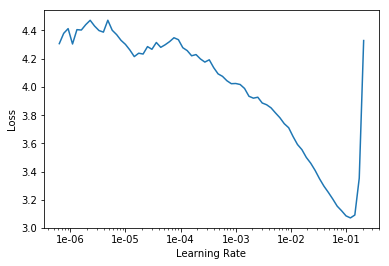

In [14]:
# Find a good learning rate
learn.lr_find()
learn.recorder.plot()

In [15]:
lr = 1e-2
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,1.957371,0.655385,0.773266,07:25
1,1.024398,0.482041,0.829866,07:23
2,0.709102,0.450039,0.841918,07:23


Now switching to 224x224 size which is usually used for ResNet 50:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


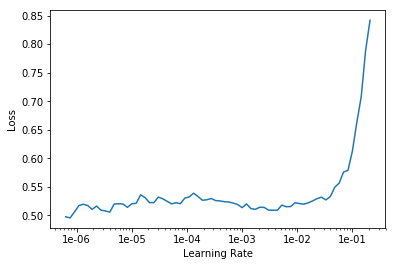

In [16]:
# progressive resizing
learn.data = data = (
    src.transform(tfms,size=224)
    .databunch()
    .normalize(imagenet_stats)
)
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.539580,0.487397,0.826789,07:45
1,0.524980,0.668127,0.750594,07:43
2,0.479915,0.357809,0.870329,07:41
3,0.428281,0.356579,0.865766,07:39
4,0.364786,0.299730,0.897332,07:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


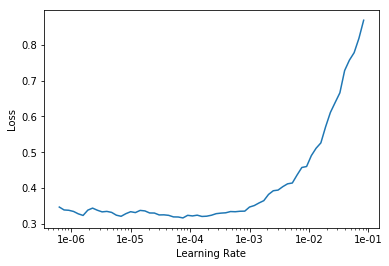

In [18]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.334919,0.312794,0.886683,07:44
1,0.327612,0.318333,0.896684,07:42
2,0.327048,0.279965,0.904075,07:43
3,0.313733,0.272321,0.903197,07:42
4,0.295878,0.271093,0.904973,07:47


# Metric Optimization

This part is taken from @abhishek great kernel: https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa

In [20]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)

In [21]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [22]:
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])

0.911048951048951


In [23]:
coefficients = optR.coefficients()
print(coefficients)

[0.531915 1.400079 2.44928  3.546698]




# Predictions

In [24]:
# test_df = pd.read_csv(PATH/'test.csv')
# test_df.head()
sample_df = pd.read_csv(PATH/'sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [25]:
learn.data.add_test(ImageList.from_df(sample_df,PATH,folder='test_images',suffix='.png'))

In [26]:
preds,y = learn.get_preds(DatasetType.Test)


In [27]:
test_predictions = optR.predict(preds, coefficients)

In [28]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [29]:
sample_df.to_csv('submission.csv',index=False)